#***Clustering evaluation: Internal measures***
###Rodrigo Borela $\bullet$ rborelav@gatech.edu

In [71]:
# import useful modules
import numpy as np
import matplotlib.pyplot as plt
# (we are going to cheat a little bit and use sklearn for the sake of convenience ;P)
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

# BETA-CV

## 1. Computing the weights
$$W\left(S,R\right)=\sum_{\mathbf{x}_i\in\ S}\sum_{\mathbf{x}_j\in\ R}\ w_{ij}$$

$$W_{in}=\frac{1}{2}\sum_{i=1}^{K}W\left(C_i,C_i\right)$$

$$W_{out}=\frac{1}{2}\sum_{i=1}^{K}W\left(C_i,\bar{C_i}\right)=\sum_{i=1}^{K-1}\sum_{j>i}\ W\left(C_i,C_j\right)$$

## 2. Computing the number of pairs
$$N_{in}=\sum_{i=1}^{K}\left(\begin{matrix}n_i\\2\\\end{matrix}\right)$$

$$N_{out}=\sum_{i=1}^{K-1}\sum_{j=i+1}^{K}{n_i\times n_j}$$


## 3. Computing the BetaCV measure
$$BetaCV=\frac{\frac{W_{in}}{N_{in}}}{\frac{W_{out}}{N_{out}}}=\frac{N_{out}}{N_{in}}\times\frac{W_{in}}{W_{out}}=\frac{N_{out}}{N_{in}}\frac{\sum_{i=1}^{K}W\left(C_i,C_i\right)}{\sum_{i=1}^{K}W\left(C_i,\ \bar{C_i}\right)}$$

## 4. Normalized cut
$$NC = \sum_{i=1}^{K}\frac{1}{\frac{W\left(C_i,\ C_i\right)}{W\left(C_i,\ \bar{C_i}\right)}+1}$$

In [72]:
def betacv(X, labels):
    W_in, W_out = 0.0, 0.0
    N_in, N_out = 0, 0
    for k in range(len(set(labels))):
        # get points in a cluster
        X_k = X[labels == k,:]
        X_not_k = X[labels != k,:]
        # compute sum of the dist of every intracluster pair of points
        W_in_k = np.sum(pairwise_distances(X_k, X_k, metric='euclidean'))
        W_in += W_in_k
        # compute sum of the dist of every intercluster pair of points
        pw_out_k = pairwise_distances(X_k, X_not_k, metric='euclidean')
        W_out += np.sum(pw_out_k)
        # number of intracluster pairs
        N_in += X_k.shape[0] * (X_k.shape[0]-1) * .5
        # number of intercluster pairs
        N_out += pw_out_k.shape[0]*pw_out_k.shape[1]
    # correct the fact we took distances into account twice
    W_in *= 0.5
    W_out *= 0.5
    # compute BetaCV
    betaCV = (W_in/N_in)/(W_out/N_out)
    return betaCV

##Davies-bouldin index

##1. Calculate the means
$$\mu_i=\frac{1}{n_i}\sum_{\mathbf{x}_j\in C_i}\mathbf{x}_j$$

##2. Calculate the scatter
$$\sigma_{\mu_i}=\sqrt{\frac{\sum_{\mathbf{x}_j\in C_i}{{d(\mathbf{x}}_j,\mu_i)}^2}{n_i}}$$

##3. Davies-Bouldin between pairs of clusters
$$DB_{ij}=\frac{\sigma_{\mu_i}+\sigma_{\mu_j}}{d\left(\mu_i,\mu_j\right)}$$

##4. Davies-Boulding measure
$$DB=\frac{1}{K}\sum_{i=1}^{K}\max_{j\neq i}{\left\{DB_{ij}\right\}}$$

In [73]:
def daviesbouldin(X, labels):
    means = np.zeros((len(set(labels)),X.shape[1]))
    scatters = np.zeros(len(set(labels)))
    for k in range(len(set(labels))):
        # get points in a cluster
        X_k = X[labels == k,:]
        # compute the mean
        means[k,:] = np.mean(X_k,axis=0)
        # compute the scatter
        scatters[k] = np.sum(np.sum(np.abs(X_k - means[k,:])**2,axis=-1)**(0.5))
    # compute DB for each cluster pair
    DB = np.zeros((len(set(labels)),len(set(labels))))
    for i in range(len(set(labels))):
        for j in range(len(set(labels))):
                if i==j:
                    pass
                else: 
                    DB[i,j] = (scatters[i]+scatters[j])/(np.linalg.norm(means[i,:]-means[j,:]))
    # compute the Davies-Bouldin measure
    DB = np.mean(np.max(DB,axis=1))
    return DB

# Silhouette coefficient

##1. Mean intracluster pairwise distance
$$\mu_{in}\left(\mathbf{x}_i\right)=\frac{\sum_{\mathbf{x}_i\ \in\ C_{{\hat{y}}_i},j\neq i}\ d\left(\mathbf{x}_i,\mathbf{x}_j\right)}{n_{{\hat{y}}_i}-1}$$

##2. Min-mean intercluster pairwise distance
$$\mu_{out}^{min}\left(\mathbf{x}_i\right)={min}_{j\neq{\hat{y}}_i}{\left\{\frac{\sum_{\mathbf{x}\ \in C_j}\ d\left(\mathbf{x}_i,\mathbf{x}_j\right)}{n_j}\right\}}$$

##3. Silhouette coefficient
$$S_i=\frac{\mu_{out}^{min}\left(\mathbf{x}_i\right)-\mu_{in}\left(\mathbf{x}_i\right)}{max{\left\{\mu_{out}^{min}\left(\mathbf{x}_i\right),\mu_{in}\left(\mathbf{x}_i\right)\right\}}}$$

$$SC=\frac{1}{N}\sum_{i=1}^{N}Si$$


In [74]:
def silhouette(X, labels):
    mean_out = np.ones(X.shape[0])*np.nan
    mean_in = np.ones(X.shape[0])*np.nan
    for i in range(len(set(labels))):
        # get points in a cluster
        X_i = X[labels == i,:]
        # compute intracluster mean distance for each point
        mean_in[labels == i] = np.mean(pairwise_distances(X_i, X_i, metric='euclidean'),axis=1)*(len(X_i)/(len(X_i)-1))
        for j in range(len(set(labels))):
            if i != j:
                X_j = X[labels == j,:]
                # compute min mean intercluster pairwise dist for each point
                mean_out[labels==i] = np.nanmin(np.array([mean_out[labels==i], np.mean(pairwise_distances(X_i, X_j, metric='euclidean'),axis=1)]).T,axis=1)
    # compute silhoutte coefficient
    S = (mean_out-mean_in)/np.max(np.array([mean_out,mean_in]).T,axis=1)
    SC = np.mean(S)
    return SC

#TEST: Dispersion

In [75]:
# ======================
# Generate two datasets
centers = [[1, 1], [-1, -1], [1, -1]]

# === smaller variance
X_1, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.4,
                            random_state=0)
X_1 = StandardScaler().fit_transform(X_1)

# === higher variance
X_2, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.7,
                            random_state=0)
X_2 = StandardScaler().fit_transform(X_2)


# ===================
# K-MEANS CLUSTERING

# cluster the datasets
kmeans_1 = KMeans(n_clusters=3, random_state=0).fit(X_1)
labels_1 = kmeans_1.labels_

kmeans_2 = KMeans(n_clusters=3, random_state=0).fit(X_2)
labels_2 = kmeans_2.labels_

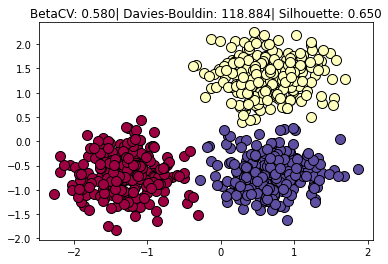

In [76]:
# =========================
# PLOT X1 (lower variance)

unique_labels = set(labels_1)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    class_member_mask = (labels_1 == k)
    xy = X_1[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=10)
plt.title('BetaCV: %5.3f' % round(betacv(X_1, labels_1),3) + ' | Davies-Bouldin: %5.3f' % round(daviesbouldin(X_1, labels_1),3) + ' | Silhouette: %5.3f' % round(silhouette(X_1, labels_1),3))
plt.show()

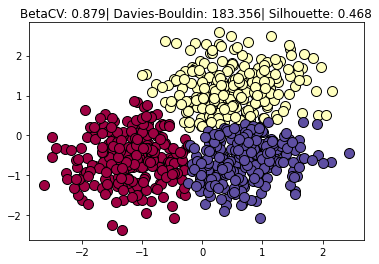

In [77]:
# =========================
# PLOT X2 (higher variance)

unique_labels = set(labels_2)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    class_member_mask = (labels_2 == k)
    xy = X_2[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=10)
plt.title('BetaCV: %5.3f' % round(betacv(X_2, labels_2),3) + ' | Davies-Bouldin: %5.3f' % round(daviesbouldin(X_2, labels_2),3) + ' | Silhouette: %5.3f' % round(silhouette(X_2, labels_2),3))
plt.show()